<a href="https://colab.research.google.com/github/Haque14/MSE504/blob/main/Module_7/MidTerm_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MidTerm - 2 for the Fall 2024 Course "Machine Learning for Materials Science", University of Tennessee Knoxville, Department of Materials Science and Engineering.

- Instructor Sergei V. Kalinin

Special point:
- ChatGPT will augment your power as a coder
- If and only if you know what you want to accomplish!

Name: Md Ershadul Haque

Department: Mechanical, Aerospace, and Biomedical Engineering

# 1.Out-of-distribution effects

Explore the out of distribution effects in VAE.
- Build the VAE or AE denoiser
- Train it on the digits [0-5]
- Quantufy performance on the digits that it was trained on (e.g. vis SSID of ground truth vs reconstruction as a function of noise)
- Quantify performance for digits [6-9]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0726 - val_loss: 0.0325
Epoch 2/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0310 - val_loss: 0.0268
Epoch 3/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0263 - val_loss: 0.0250
Epoch 4/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0242 - val_loss: 0.0232
Epoch 5/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0228 - val_loss: 0.0223
Epoch 6/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0218 - val_loss: 0.0217
Epoch 7/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0211 - val_loss: 0.0211
Epoch 8/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0205 - val_loss: 0.0206
Epoch 9/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0201 - val_loss: 0.0204
Epoch 10/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0197 - val_loss: 0.0202
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
In-dis

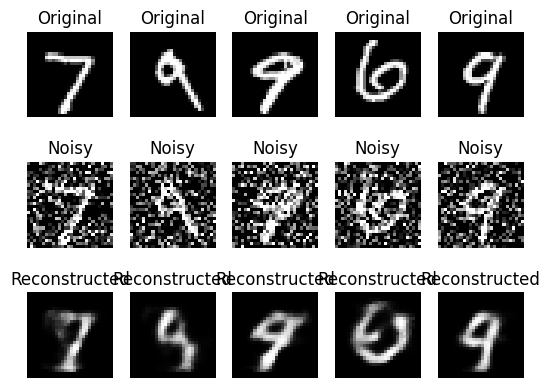

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# Load and preprocess MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0

# Filter digits
train_images_0_5 = train_images[np.isin(train_labels, [0, 1, 2, 3, 4, 5])]
test_images_0_5 = test_images[np.isin(test_labels, [0, 1, 2, 3, 4, 5])]
test_images_6_9 = test_images[np.isin(test_labels, [6, 7, 8, 9])]

# Add noise
def add_noise(images, noise_factor=0.5):
    noisy = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    return np.clip(noisy, 0.0, 1.0)

noisy_train_images = add_noise(train_images_0_5)
noisy_test_images_0_5 = add_noise(test_images_0_5)
noisy_test_images_6_9 = add_noise(test_images_6_9)

# Build Autoencoder
input_shape = train_images.shape[1:]
input_img = layers.Input(shape=input_shape)

# Encoder
x = layers.Flatten()(input_img)
x = layers.Dense(128, activation='relu')(x)
latent = layers.Dense(32, activation='relu')(x)

# Decoder
x = layers.Dense(128, activation='relu')(latent)
x = layers.Dense(np.prod(input_shape), activation='sigmoid')(x)
output_img = layers.Reshape(input_shape)(x)

# Compile model
autoencoder = models.Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='mse')

# Train model
autoencoder.fit(noisy_train_images, train_images_0_5, epochs=10, batch_size=64, validation_split=0.1)

# Evaluate performance
def evaluate_reconstruction(model, noisy_images, clean_images):
    reconstructed = model.predict(noisy_images)
    mse = np.mean((reconstructed - clean_images) ** 2)
    ssim_scores = [ssim(clean, recon, data_range=1.0) for clean, recon in zip(clean_images, reconstructed)]
    return mse, np.mean(ssim_scores)

mse_in, ssim_in = evaluate_reconstruction(autoencoder, noisy_test_images_0_5, test_images_0_5)
mse_out, ssim_out = evaluate_reconstruction(autoencoder, noisy_test_images_6_9, test_images_6_9)

print(f"In-distribution MSE: {mse_in}, SSIM: {ssim_in}")
print(f"Out-of-distribution MSE: {mse_out}, SSIM: {ssim_out}")

# Visualize samples
def plot_reconstructions(model, noisy_images, clean_images, num_samples=5):
    reconstructed = model.predict(noisy_images)
    for i in range(num_samples):
        plt.subplot(3, num_samples, i+1)
        plt.imshow(clean_images[i], cmap='gray')
        plt.title("Original")
        plt.axis('off')

        plt.subplot(3, num_samples, i+1+num_samples)
        plt.imshow(noisy_images[i], cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

        plt.subplot(3, num_samples, i+1+2*num_samples)
        plt.imshow(reconstructed[i], cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

plot_reconstructions(autoencoder, noisy_test_images_0_5, test_images_0_5)
plot_reconstructions(autoencoder, noisy_test_images_6_9, test_images_6_9)
plt.show()


# 2.Explainable ML

- Build the classified for the fashion MNIST data set
- Use LIME or SHAP to explain the predictions

In [2]:
pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=fadf9a6762fe4a9a5fe59dc3121178cc08ab3e074d9785df45a57acac4fc4afa
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

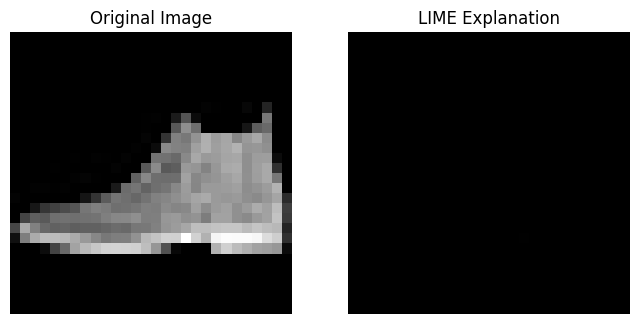

In [6]:
# LIME Explanation
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np

# Instantiate LIME explainer
explainer = lime_image.LimeImageExplainer()

# Select a test image
idx = 0  # Choose an index from the test set
image = x_test[idx]

# Custom classifier function to handle LIME's perturbed inputs
def classifier_fn(images):
    # Convert RGB images (28, 28, 3) to grayscale (28, 28, 1)
    grayscale_images = np.expand_dims(np.mean(images, axis=-1), axis=-1)
    return model.predict(grayscale_images)

# Explain prediction
explanation = explainer.explain_instance(
    image=image.squeeze(),  # Remove channel dimension for LIME
    classifier_fn=classifier_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000  # Number of perturbations
)

# Visualize explanation
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    hide_rest=False,
    min_weight=0.1
)

# Plot LIME results
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("LIME Explanation")
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.axis('off')

plt.show()


# 3.Molecular discovery

- We extract information from QM9 dataset, particularly from each molecule (given orignially in .xyz format) followed by computing features using rdkit and then combine those into a dataframe.
- Link to orginal dataset: http://quantum-machine.org/datasets/
- Link where we can find the functionalities represented by variables in the 'parser' code. For example 'mu' represents the dipole moment. https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM9.html

- Adapted from notebook prepared by Ayana Ghosh, research.aghosh@gmail.com

## Install RDkit and Selfies

In [7]:
!pip install rdkit-pypi
!pip install selfies --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 40.5 MB/s eta 0:00:00


In [8]:
import numpy as np
import pandas as pd

import glob

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors

import torch
from math import log
import matplotlib.pyplot as plt
from pandas import json_normalize

import selfies as sf

In [9]:
def parse_float(s: str) -> float:
    try:
        return float(s)
    except ValueError:
        base, power = s.split('*^')
        return float(base) * 10**float(power)

def parse_xyz(filename):
    """
    Parses QM9 specific xyz files.
    :param filename: str path to file
    :return:
    """
    num_atoms = 0
    scalar_properties = []
    atomic_symbols = []
    xyz = []
    charges = []
    harmonic_vibrational_frequencies = []
    smiles = ''
    inchi = ''
    with open(filename, 'r') as f:
        for line_num, line in enumerate(f):
            if line_num == 0:
                num_atoms = int(line)
            elif line_num == 1:
                scalar_properties = [float(i) for i in line.split()[2:]]
            elif 2 <= line_num <= 1 + num_atoms:
                atom_symbol, x, y, z, charge = line.split()
                atomic_symbols.append(atom_symbol)
                xyz.append([parse_float(x), parse_float(y), parse_float(z)])
                charges.append(parse_float(charge))
            elif line_num == num_atoms + 2:
                harmonic_vibrational_frequencies = [float(i) for i in line.split()]
            elif line_num == num_atoms + 3:
                smiles = line.split()[0]
            elif line_num == num_atoms + 4:
                inchi = line.split()[0]

    result = {
        'num_atoms': num_atoms,
        'atomic_symbols': atomic_symbols,
        'pos': torch.tensor(xyz),
        'charges': np.array(charges),
        'harmonic_oscillator_frequencies': harmonic_vibrational_frequencies,
        'smiles': smiles,
        'inchi': inchi
    }
    scalar_property_labels = ['A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'u0', 'u', 'h', 'g', 'cv']
    scalar_properties = dict(zip(scalar_property_labels, scalar_properties))
    result.update(scalar_properties)
    return result

## Download the data

In [10]:
!gdown https://drive.google.com/uc?id=1At3XHtaXXY3Qr4RIQ1Vua2_dRKoGyyEF

Downloading...
From (original): https://drive.google.com/uc?id=1At3XHtaXXY3Qr4RIQ1Vua2_dRKoGyyEF
From (redirected): https://drive.google.com/uc?id=1At3XHtaXXY3Qr4RIQ1Vua2_dRKoGyyEF&confirm=t&uuid=e68458db-868c-491f-a4ec-b12667154005
To: /content/dsgdb9nsd.xyz.tar.bz2
100% 86.1M/86.1M [00:01<00:00, 74.2MB/s]


Generate lists of SMILE strings and append with properties that we can directly retrieve from the QM9 dataset

What are SMILES and when were they invented (note that ChatGPT is unlikely to produce the correct citation - so Wikipedia can help)?

Answer:

**SMILES** (Simplified Molecular Input Line Entry System) is a notation system used to represent the structure of chemical molecules as strings. It encodes molecular structure in a compact and human-readable form, making it useful for cheminformatics and machine learning applications.

**When Were SMILES Invented?**

SMILES was invented by David Weininger in the 1980s. It became widely used due to its simplicity and integration into cheminformatics software.

In [11]:
!mkdir /content/Molecules
!tar -C Molecules -xvf /content/dsgdb9nsd.xyz.tar.bz2

Streaming output truncated to the last 5000 lines.
dsgdb9nsd_128886.xyz
dsgdb9nsd_128887.xyz
dsgdb9nsd_128888.xyz
dsgdb9nsd_128889.xyz
dsgdb9nsd_128890.xyz
dsgdb9nsd_128891.xyz
dsgdb9nsd_128892.xyz
dsgdb9nsd_128893.xyz
dsgdb9nsd_128894.xyz
dsgdb9nsd_128895.xyz
dsgdb9nsd_128896.xyz
dsgdb9nsd_128897.xyz
dsgdb9nsd_128898.xyz
dsgdb9nsd_128899.xyz
dsgdb9nsd_128900.xyz
dsgdb9nsd_128901.xyz
dsgdb9nsd_128902.xyz
dsgdb9nsd_128903.xyz
dsgdb9nsd_128904.xyz
dsgdb9nsd_128905.xyz
dsgdb9nsd_128906.xyz
dsgdb9nsd_128907.xyz
dsgdb9nsd_128908.xyz
dsgdb9nsd_128909.xyz
dsgdb9nsd_128910.xyz
dsgdb9nsd_128911.xyz
dsgdb9nsd_128912.xyz
dsgdb9nsd_128913.xyz
dsgdb9nsd_128914.xyz
dsgdb9nsd_128915.xyz
dsgdb9nsd_128916.xyz
dsgdb9nsd_128917.xyz
dsgdb9nsd_128918.xyz
dsgdb9nsd_128919.xyz
dsgdb9nsd_128920.xyz
dsgdb9nsd_128921.xyz
dsgdb9nsd_128922.xyz
dsgdb9nsd_128923.xyz
dsgdb9nsd_128924.xyz
dsgdb9nsd_128925.xyz
dsgdb9nsd_128926.xyz
dsgdb9nsd_128927.xyz
dsgdb9nsd_128928.xyz
dsgdb9nsd_128929.xyz
dsgdb9nsd_128930.xyz
dsgd

In [12]:
smiles = []
enthalpy = []
u0 = []
u = []
g = []
alpha = []
r2 = []
mu = []

#may need to change the path
filenames = glob.glob('/content/Molecules/*.xyz')

#may need to go through the full range
for fid in range(5000):
    x = parse_xyz(filenames[fid])
    smiles_loc = x['smiles']
    enthalpy_loc = x['h']
    dipole_moment = x['mu']
    homo_loc = x['homo']
    lumo_loc = x['lumo']
    gap_loc = x['gap']
    zpve_loc = x['zpve']
    u0_loc = x['u0']
    u_loc = x['u']
    g_loc = x['g']
    alpha_loc = x['alpha']
    r2_loc = x['r2']
    smiles.append(smiles_loc)
    mu.append(dipole_moment)
    enthalpy.append(enthalpy_loc)
    u0.append(u0_loc)
    u.append(u_loc)
    g.append(g_loc)
    alpha.append(alpha_loc)
    r2.append(r2_loc)

Let's compute few basic features and put together a dataset. Features we compute:
- molecular weight,
- topological polar surface area,
- molar log P,
- number of hydrogen bond donors,
- acceptors,
- valence electrons,
- maximum partial charge,
- minimum partial charge,
- number of rotatable bonds,
- number of ring counts,
- number of stereocenters

In [13]:
mol_wt, tpsa, logp_ml, hbd, hba  = [], [], [], [], []
vale, partialcg_max, partialcg_min, rotbd, ringct, stereoct = [], [], [], [], [], []

for i in range(len(smiles)):
    m = Chem.MolFromSmiles(smiles[i])
    mol_wt_l = Descriptors.ExactMolWt(m)
    tpsa_l, logp_l = Descriptors.TPSA(m), Descriptors.MolLogP(m)
    hbd_l, hba_l = Descriptors.NumHDonors(m), Descriptors.NumHAcceptors(m)
    vale_l = Descriptors.NumValenceElectrons(m),
    partialcharge_max_l, partialcharge_min_l = Descriptors.MaxPartialCharge(m), Descriptors.MinPartialCharge(m)
    rotbd_l = Descriptors.NumRotatableBonds(m)
    ring_ct, stereo_cent = Descriptors.RingCount(m), rdMolDescriptors.CalcNumAtomStereoCenters(m)

    mol_wt.append(mol_wt_l)
    tpsa.append(tpsa_l)
    logp_ml.append(logp_l)
    hbd.append(hbd_l)
    hba.append(hba_l)
    vale.append(vale_l)
    partialcg_max.append(partialcharge_max_l)
    partialcg_min.append(partialcharge_min_l)
    rotbd.append(rotbd_l)
    ringct.append(ring_ct)
    stereoct.append(stereo_cent)

New dataset with few features with SMILE strings

In [14]:
df = pd.DataFrame({'smiles': smiles, 'mole_logp': logp_ml,'tpsa': tpsa, 'mol_wt' : mol_wt,
                   'hbd': hbd, 'hba':hba, 'valencee':vale, 'max_partialcharge':partialcg_max, 'min_partialcharge':partialcg_min,
                   'rotatablebd':rotbd, 'ringct':ringct, 'stereocent': stereoct, 'dipole_moment':mu})

In [15]:
df

,smiles,mole_logp,tpsa,mol_wt,hbd,hba,valencee,max_partialcharge,min_partialcharge,rotatablebd,ringct,stereocent,dipole_moment
0,OC12CC1NC(=O)NC2,-1.1974,61.36,128.058577,3,2,"(50,)",0.314713,-0.385808,0,2,2,3.9760
1,CCC(CC)OC(C)=O,1.7381,26.30,130.099380,0,2,"(54,)",0.302399,-0.462589,3,0,0,1.8965
2,CN1N=NC=C1O,-0.4793,50.94,99.043262,1,4,"(38,)",0.229222,-0.492311,0,1,0,4.5328
3,OC1CCC2NC12,-0.5185,42.17,99.068414,2,2,"(40,)",0.070865,-0.391442,0,2,3,2.3021
4,CN(C)C(=O)C1CN1,-0.9536,42.25,114.079313,1,2,"(46,)",0.240008,-0.347424,1,1,1,3.8666
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,CC1CC23COC2C1O3,0.5626,18.46,126.068080,0,2,"(50,)",0.120857,-0.369277,0,4,4,0.6555
4996,NC1=CC([O-])=C(C[NH3+])O1,-1.3227,89.86,128.058577,2,3,"(50,)",0.189638,-0.869905,1,1,0,4.8430
4997,CC12NC1CCC21CN1,-0.1473,43.88,124.100048,2,2,"(50,)",0.050580,-0.306490,0,3,3,2.3438
4998,O=CCC12CN(C1)C2,-0.1090,20.31,111.068414,0,2,"(44,)",0.120193,-0.303377,2,3,0,2.0644


## Convert SMILEs to SELFIEs

As an excercise, read the SELFIES paper (https://github.com/aspuru-guzik-group/selfies) and describe the difference between SMILES and SELFIEs

Answer:  

**Comparison table between SMILES and SELFIES**

| **Aspect**          | **SMILES**                                                  | **SELFIES**                                             |
|----------------------|------------------------------------------------------------|--------------------------------------------------------|
| **Validity**         | Strings can be invalid.                                     | All strings represent valid molecules.                |
| **Mutations**        | Often lead to invalid molecules.                            | Always result in valid molecules.                     |
| **Representation**   | Non-local, requires additional rules for rings and branches.| Local, simplifies handling of branches and rings.     |
| **Machine Learning** | Requires preprocessing and validation.                      | Directly usable in ML models.                         |
| **Complexity**       | May fail for large or complex molecules.                    | Scalable to larger molecules and diverse graphs.      |


In [16]:
smiles

['OC12CC1NC(=O)NC2',
 'CCC(CC)OC(C)=O',
 'CN1N=NC=C1O',
 'OC1CCC2NC12',
 'CN(C)C(=O)C1CN1',
 'NC1=C(NC(O)=N1)C#C',
 'CCCCNCC#N',
 'CCC12C3CC=C1CN23',
 'CC1=CCC2OCC=C12',
 'CC(C)C1CC(C)C1O',
 'C1CC11OC2CCC1C2',
 'O=C1OC2CC2N2CC12',
 'O=C1OCCCO1',
 'COC12CC1(O)C=CC2',
 'CC1C2CCC12C(N)=O',
 'O=CC1=CC2(CC2)OC1',
 'O=CC12CN(C1)CCN2',
 'OC12CCC11CCC2O1',
 'CN1CC1COC=O',
 'OC1CC(CC2CO2)C1',
 'CC12NC1C1NC1C=C2',
 'O=CCC(=O)CC1CO1',
 'CCC(=O)C1(C)CO1',
 'CC1CC(O)CC(=O)O1',
 'CC(C#N)N1CC2CC12',
 'COCC1CCC1CO',
 'OC1C(COC1=O)C#C',
 'O=CN1CCC1C1CO1',
 'C1OC2C3OC3CC2=C1',
 'CC1C2C3OCC3(C)N12',
 'CCC(C)(O)C1COC1',
 'OCC1C2OC2C1C#C',
 'COC(=O)C1CC2CN12',
 'CC12CC(O)C3C1CN23',
 'C1CC2(O1)C1CCC21',
 'CCC(C)N(C)C=O',
 'NC12CC1C(O)C2C#N',
 'CC1OC2CCC2=C1',
 'CC(CC=O)C#CC=O',
 'OC12C=CCN3C1CC23',
 'C1OCC1C1COC1',
 'OCC1C=CCC1=NO',
 'CCC1CCC(=O)C1O',
 'CC(CCCO)CC=O',
 'O=C1CCCCNC=C1',
 'C#CCCC1(CC1)C#C',
 'NC1=C(C#N)C(O)=CN1',
 'CCCC1(CO)CO1',
 'N=C1NCC2OC1C2=O',
 'CC12CC1C1CC1O2',
 'CC(C1CO1)C(=O)C#C',
 '

The SELFIES have some limitations on acceptable bonding. So we refine the data set to remove the molecules that do not fit into supported semantic constraints.

In [19]:
selfies_dataset = []
error_smiles = []

for i, smi in enumerate(smiles):  # Use enumerate for readability
    try:
        # Attempt to encode SMILES into SELFIES
        local_sf = sf.encoder(smi)
        selfies_dataset.append(local_sf)
    except Exception as e:
        # Log error with SMILES and reason
        print(f"Error encoding SMILES at index {i} ({smi}): {e}")
        error_smiles.append(smi)  # Store problematic SMILES
        continue  # Proceed to the next SMILES


Error encoding SMILES at index 178 (CC1=NC=C(O1)N(=O)=O): input violates the currently-set semantic constraints
	SMILES: CC1=NC=C(O1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 1280 (OC1=CNC(=C1)N(=O)=O): input violates the currently-set semantic constraints
	SMILES: OC1=CNC(=C1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 1632 (O=N(=O)C1=CNN=C1): input violates the currently-set semantic constraints
	SMILES: O=N(=O)C1=CNN=C1
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 2507 (CN1C=CN=C1N(=O)=O): input violates the currently-set semantic constraints
	SMILES: CN1C=CN=C1N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 3903 (CC1=CC=C(O1)N(=O)=O): input violates the currently-set semantic constraints
	SMILES: CC1=CC=C(O1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. 

Let's see what these molecules are....

In [20]:
error_smiles_set = set(error_smiles)
error_smiles_set

{'CC1=CC=C(O1)N(=O)=O',
 'CC1=CNC=C1N(=O)=O',
 'CC1=NC=C(O1)N(=O)=O',
 'CN1C=CN=C1N(=O)=O',
 'O=N(=O)C1=CN=NC=N1',
 'O=N(=O)C1=CNN=C1',
 'OC1=CNC(=C1)N(=O)=O'}

... how many of them are there

In [21]:
df['smiles'].isin(error_smiles_set).sum()

7

And remove them from the dataframe

In [22]:
df_filtered = df[~df['smiles'].isin(error_smiles_set)]
df_filtered.tail(5)

,smiles,mole_logp,tpsa,mol_wt,hbd,hba,valencee,max_partialcharge,min_partialcharge,rotatablebd,ringct,stereocent,dipole_moment
4995,CC1CC23COC2C1O3,0.5626,18.46,126.068080,0,2,"(50,)",0.120857,-0.369277,0,4,4,0.6555
4996,NC1=CC([O-])=C(C[NH3+])O1,-1.3227,89.86,128.058577,2,3,"(50,)",0.189638,-0.869905,1,1,0,4.8430
4997,CC12NC1CCC21CN1,-0.1473,43.88,124.100048,2,2,"(50,)",0.050580,-0.306490,0,3,3,2.3438
4998,O=CCC12CN(C1)C2,-0.1090,20.31,111.068414,0,2,"(44,)",0.120193,-0.303377,2,3,0,2.0644
4999,CC1(COC2CC2)CC1,1.9655,9.23,126.104465,0,1,"(52,)",0.057691,-0.377654,3,2,0,0.8829


Now, let's generate one-hot encodings.

In [23]:
#for producing corresponding one-hot vectors
alphabet = sf.get_alphabet_from_selfies(selfies_dataset)
alphabet.add("[nop]")  # [nop] is a special padding symbol
alphabet = list(sorted(alphabet))

pad_to_len = max(sf.len_selfies(s) for s in selfies_dataset)
symbol_to_idx = {s: i for i, s in enumerate(alphabet)}

labels = []
one_hot_vectors = []
for i in range(len(selfies_dataset)):

  label, one_hot = sf.selfies_to_encoding(selfies=selfies_dataset[i], vocab_stoi=symbol_to_idx,
                                          pad_to_len=pad_to_len, enc_type="both")
  labels.append(label)
  one_hot_vectors.append(one_hot)

np.array(one_hot_vectors).shape

(4993, 21, 26)

Explore the code segment above. What is:
- alphabet
- symbol_to_idx
- what are the dimensionalities of the np.array(one_hot_vectors).shape

Answer:

| **Variable**          | **Definition**                                                                                 | **Dimensionality Example**    |
|-----------------------|-----------------------------------------------------------------------------------------------|--------------------------------|
| **`alphabet`**        | Set of unique symbols in the SELFIES dataset, including `[nop]`.                              | `len(alphabet) = 30`          |
| **`symbol_to_idx`**   | Dictionary mapping each symbol in `alphabet` to a unique integer index.                       | `len(symbol_to_idx) = 30`     |
| **`np.array(one_hot_vectors).shape`** | Shape of the one-hot encoding array for all SELFIES strings.                       | `(100, 50, 30)`               |



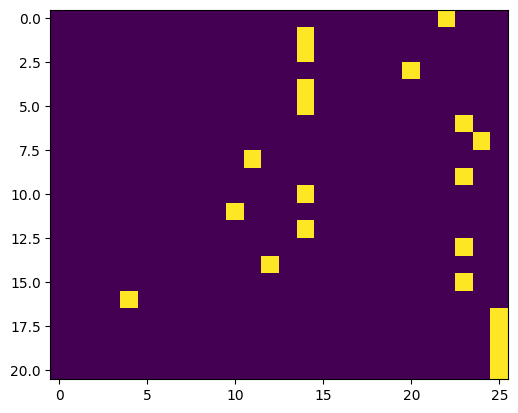

In [24]:
plt.imshow(np.array(one_hot_vectors)[310,:,:])

Now, let's explore the properties of the latent space of this dataset. Using ChaGPT:
- Write the AE using the encoded smiles as an input with 2D latent space
-  Visualize the latent distribution and representation
- Experiment with difefrent attributes from data frame as labels, and see how they are distirbuted in latent space

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 21, 26)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 2)                   │          78,402 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 21, 26)              │          78,946 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 157,348 (614.64 KB)

 Trainable params: 157,348 (614.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1131 - val_loss: 0.0213
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0209 - val_loss: 0.0210
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0206 - val_loss: 0.0207
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0201 - val_loss: 0.0189
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0183 - val_loss: 0.0180
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0177 - val_loss: 0.0177
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175 - val_loss: 0.0175
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0173 - val_loss: 0.0174
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0171 - val_loss: 0.0173
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0171 - val_loss: 0.0172
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0170 - val_loss: 0.0170
Epoch 12/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/ste

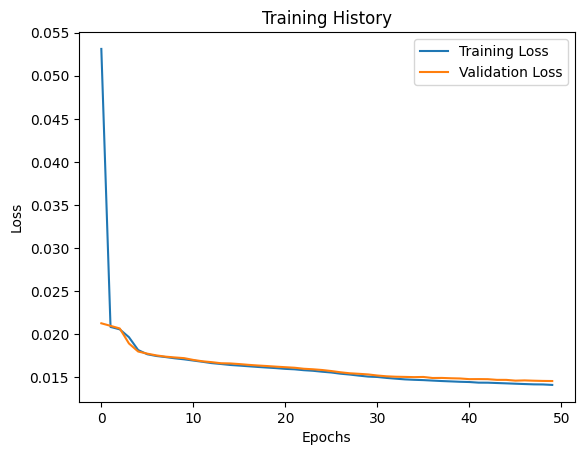

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Available columns in DataFrame: Index(['smiles', 'mole_logp', 'tpsa', 'mol_wt', 'hbd', 'hba', 'valencee',
       'max_partialcharge', 'min_partialcharge', 'rotatablebd', 'ringct',
       'stereocent', 'dipole_moment'],
      dtype='object')


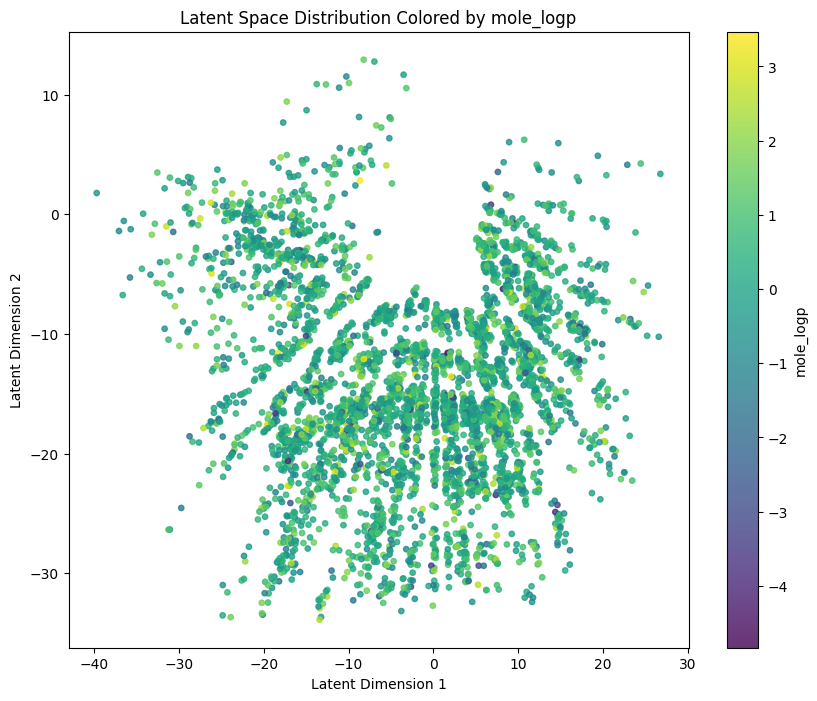

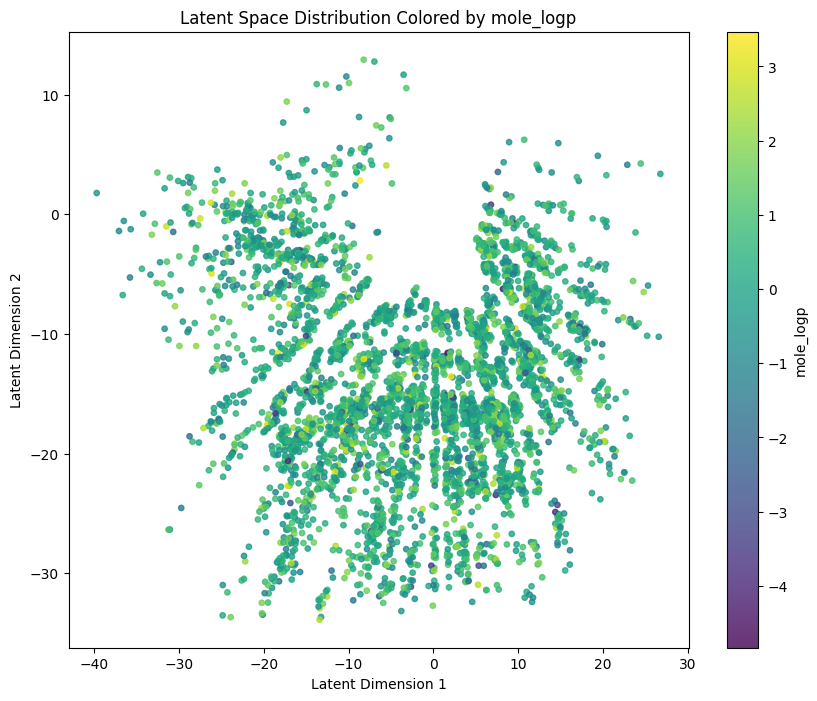

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
import pandas as pd

# Assuming `one_hot_vectors` and `df` are already available
# `one_hot_vectors`: One-hot encodings of SMILES
# `df`: DataFrame containing molecular properties like `logP`, `tpsa`, etc.

# Prepare the data
X = np.array(one_hot_vectors)  # Convert one-hot encodings to a numpy array
input_shape = X.shape[1:]  # Shape of input: (pad_to_len, len(alphabet))
latent_dim = 2  # Dimensionality of the latent space

# --- Define the Autoencoder ---
# Encoder
input_layer = Input(shape=input_shape, name="input_layer")
x = Flatten()(input_layer)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
latent_layer = Dense(latent_dim, activation=None, name="latent_layer")(x)

# Decoder
decoder_input = Input(shape=(latent_dim,), name="decoder_input")
x = Dense(64, activation="relu")(decoder_input)
x = Dense(128, activation="relu")(x)
x = Dense(np.prod(input_shape), activation="sigmoid")(x)  # Match input size
output_layer = Reshape(input_shape, name="output_layer")(x)

# Models
encoder = Model(input_layer, latent_layer, name="encoder")
decoder = Model(decoder_input, output_layer, name="decoder")
autoencoder = Model(input_layer, decoder(encoder(input_layer)), name="autoencoder")

# Compile the autoencoder
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
autoencoder.summary()

# --- Train the Autoencoder ---
history = autoencoder.fit(X, X, epochs=50, batch_size=32, validation_split=0.2)

# --- Visualize Training History ---
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# --- Encode Data into Latent Space ---
latent_space = encoder.predict(X)

# --- Verify Column Names in DataFrame ---
print("Available columns in DataFrame:", df.columns)

# Ensure DataFrame rows correspond to the latent space entries
df_filtered = df.iloc[:latent_space.shape[0]]  # Adjust DataFrame to match latent space

# Select a property for visualization
property_name = 'mole_logp'  # Replace with the desired column name
if property_name not in df_filtered.columns:
    raise KeyError(f"Column '{property_name}' not found in the DataFrame. Available columns: {list(df_filtered.columns)}")

# Extract property values
labels = df_filtered[property_name].values

# --- Visualize Latent Space ---
plt.figure(figsize=(10, 8))
plt.scatter(latent_space[:, 0], latent_space[:, 1], c=labels, cmap="viridis", s=15, alpha=0.8)
plt.colorbar(label=f"{property_name}")
plt.title(f"Latent Space Distribution Colored by {property_name}")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()

# Ensure DataFrame rows correspond to latent space entries
df_filtered = df.iloc[:latent_space.shape[0]]  # Adjust DataFrame to match latent space

# Select a property for visualization
property_name = 'mole_logp'  # Replace with the desired property
if property_name not in df_filtered.columns:
    raise KeyError(f"Column '{property_name}' not found in the DataFrame. Available columns: {list(df_filtered.columns)}")

# Extract property values
labels = df_filtered[property_name].values

# Ensure labels match latent space size
if len(labels) != latent_space.shape[0]:
    raise ValueError(f"Mismatch: {len(labels)} labels vs {latent_space.shape[0]} latent space points.")

# --- Visualize Latent Space ---
plt.figure(figsize=(10, 8))
plt.scatter(latent_space[:, 0], latent_space[:, 1], c=labels, cmap="viridis", s=15, alpha=0.8)
plt.colorbar(label=f"{property_name}")
plt.title(f"Latent Space Distribution Colored by {property_name}")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()



Do the same with the VAE, also with 2D latent space

Epoch [1/50], Loss: 0.2617
Epoch [2/50], Loss: 0.2401
Epoch [3/50], Loss: 0.2269
Epoch [4/50], Loss: 0.2096
Epoch [5/50], Loss: 0.1948
Epoch [6/50], Loss: 0.1772
Epoch [7/50], Loss: 0.1650
Epoch [8/50], Loss: 0.1571
Epoch [9/50], Loss: 0.1324
Epoch [10/50], Loss: 0.0969
Epoch [11/50], Loss: 0.0942
Epoch [12/50], Loss: 0.0781
Epoch [13/50], Loss: 0.0826
Epoch [14/50], Loss: 0.0674
Epoch [15/50], Loss: 0.0635
Epoch [16/50], Loss: 0.0606
Epoch [17/50], Loss: 0.0571
Epoch [18/50], Loss: 0.0581
Epoch [19/50], Loss: 0.0551
Epoch [20/50], Loss: 0.0567
Epoch [21/50], Loss: 0.0543
Epoch [22/50], Loss: 0.0543
Epoch [23/50], Loss: 0.0539
Epoch [24/50], Loss: 0.0561
Epoch [25/50], Loss: 0.0547
Epoch [26/50], Loss: 0.0572
Epoch [27/50], Loss: 0.0526
Epoch [28/50], Loss: 0.0538
Epoch [29/50], Loss: 0.0545
Epoch [30/50], Loss: 0.0532
Epoch [31/50], Loss: 0.0546
Epoch [32/50], Loss: 0.0546
Epoch [33/50], Loss: 0.0545
Epoch [34/50], Loss: 0.0518
Epoch [35/50], Loss: 0.0510
Epoch [36/50], Loss: 0.0517
E

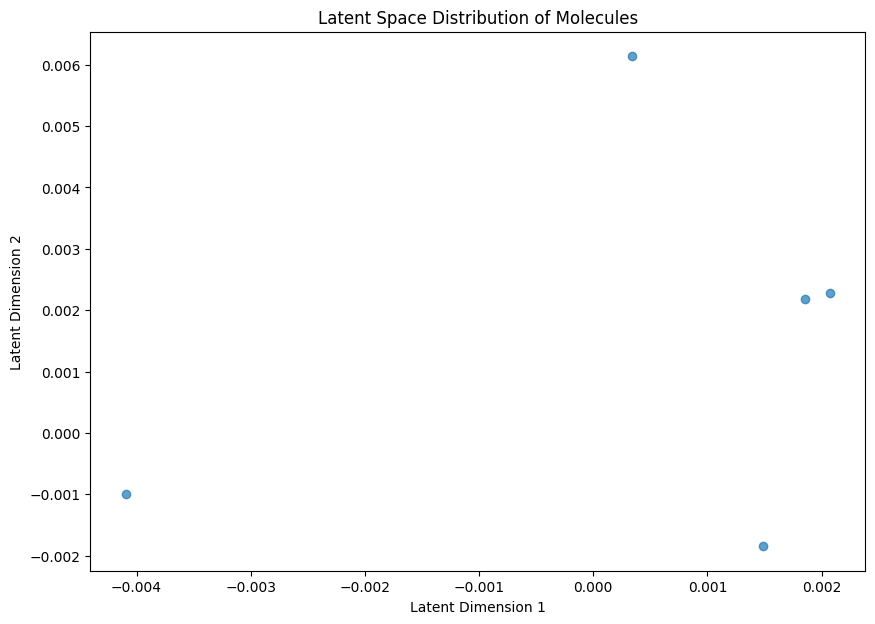

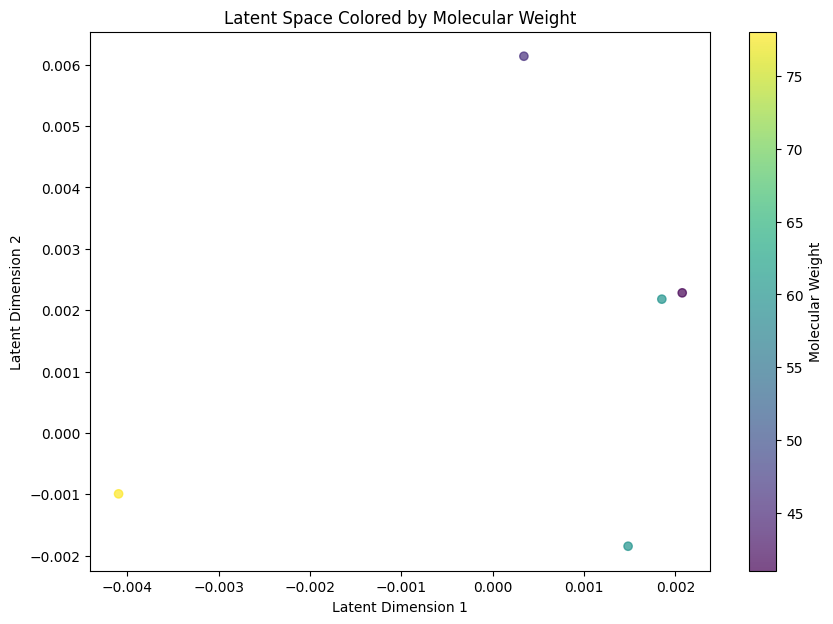

In [43]:
import selfies as sf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors

# Step 1: Prepare a List of SMILES Strings
smiles = [
    "CCO",  # Ethanol
    "C1=CC=CC=C1",  # Benzene
    "CC(=O)O",  # Acetic acid
    "C[C@H](O)C",  # Lactic acid
    "N#CC"  # Acetonitrile
]

# Convert SMILES to SELFIES and compute properties
selfies_dataset = []
error_smiles = []
mol_wt, logp_ml = [], []

for smile in smiles:
    try:
        # Convert SMILES to SELFIES
        selfie = sf.encoder(smile)
        selfies_dataset.append(selfie)

        # Calculate molecular properties
        mol = Chem.MolFromSmiles(smile)
        mol_wt.append(Descriptors.ExactMolWt(mol))
        logp_ml.append(Descriptors.MolLogP(mol))
    except Exception as e:
        print(f"Error processing SMILES: {smile} -> {e}")
        error_smiles.append(smile)

# Create a DataFrame with molecular properties
df = pd.DataFrame({
    'smiles': smiles[:len(selfies_dataset)],
    'mol_wt': mol_wt,
    'mole_logp': logp_ml
})

# Generate one-hot encodings for SELFIES
alphabet = sf.get_alphabet_from_selfies(selfies_dataset)
alphabet.add("[nop]")  # Add padding symbol
alphabet = list(sorted(alphabet))

pad_to_len = max(sf.len_selfies(s) for s in selfies_dataset)
symbol_to_idx = {s: i for i, s in enumerate(alphabet)}
vocab_size = len(alphabet)

one_hot_vectors = []
for selfie in selfies_dataset:
    one_hot = sf.selfies_to_encoding(
        selfies=selfie, vocab_stoi=symbol_to_idx, pad_to_len=pad_to_len, enc_type="one_hot"
    )
    one_hot_vectors.append(one_hot)

one_hot_vectors = np.array(one_hot_vectors)
input_dim = one_hot_vectors.shape[2]
sequence_length = one_hot_vectors.shape[1]
num_samples = one_hot_vectors.shape[0]

# Step 2: Define the VAE Architecture
class VAE(nn.Module):
    def __init__(self, input_dim, sequence_length, latent_dim=2):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim * sequence_length, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU()
        )
        self.mu = nn.Linear(128, latent_dim)
        self.log_var = nn.Linear(128, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim * sequence_length),
            nn.Sigmoid(),
            nn.Unflatten(1, (sequence_length, input_dim))
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu(h)
        log_var = self.log_var(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstructed = self.decode(z)
        return reconstructed, mu, log_var

# Step 3: Initialize the Model, Optimizer, and Loss
latent_dim = 2
model = VAE(input_dim, sequence_length, latent_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 4: Define the VAE Loss Function
def vae_loss(reconstructed, x, mu, log_var):
    reconstruction_loss = criterion(reconstructed, x)
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence / x.size(0)

# Step 5: Train the VAE
x_data = torch.tensor(one_hot_vectors, dtype=torch.float32)
epochs = 50
batch_size = min(16, num_samples)

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(x_data.size(0))
    epoch_loss = 0

    for i in range(0, x_data.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_x = x_data[indices]
        reconstructed, mu, log_var = model(batch_x)
        loss = vae_loss(reconstructed, batch_x, mu, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

# Step 6: Visualize Latent Space
model.eval()
with torch.no_grad():
    mu, _ = model.encode(x_data)
    latent_vectors = mu.numpy()

plt.figure(figsize=(10, 7))
plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], alpha=0.7)
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Distribution of Molecules")
plt.show()

# Step 7: Visualize Latent Space Colored by Molecular Weight
plt.figure(figsize=(10, 7))
sc = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=df['mol_wt'], cmap='viridis', alpha=0.7)
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Colored by Molecular Weight")
plt.colorbar(sc, label="Molecular Weight")
plt.show()


Write the VAE with the 10D latent space. Suggest an approach to visualize the latent space

Epoch [1/50], Loss: 0.2781
Epoch [2/50], Loss: 0.2471
Epoch [3/50], Loss: 0.2233
Epoch [4/50], Loss: 0.2140
Epoch [5/50], Loss: 0.1987
Epoch [6/50], Loss: 0.1746
Epoch [7/50], Loss: 0.1617
Epoch [8/50], Loss: 0.1489
Epoch [9/50], Loss: 0.1465
Epoch [10/50], Loss: 0.1296
Epoch [11/50], Loss: 0.1087
Epoch [12/50], Loss: 0.1111
Epoch [13/50], Loss: 0.0846
Epoch [14/50], Loss: 0.0717
Epoch [15/50], Loss: 0.0683
Epoch [16/50], Loss: 0.0660
Epoch [17/50], Loss: 0.0668
Epoch [18/50], Loss: 0.0600
Epoch [19/50], Loss: 0.0572
Epoch [20/50], Loss: 0.0563
Epoch [21/50], Loss: 0.0555
Epoch [22/50], Loss: 0.0552
Epoch [23/50], Loss: 0.0551
Epoch [24/50], Loss: 0.0545
Epoch [25/50], Loss: 0.0559
Epoch [26/50], Loss: 0.0549
Epoch [27/50], Loss: 0.0551
Epoch [28/50], Loss: 0.0560
Epoch [29/50], Loss: 0.0553
Epoch [30/50], Loss: 0.0545
Epoch [31/50], Loss: 0.0526
Epoch [32/50], Loss: 0.0553
Epoch [33/50], Loss: 0.0534
Epoch [34/50], Loss: 0.0543
Epoch [35/50], Loss: 0.0533
Epoch [36/50], Loss: 0.0529
E

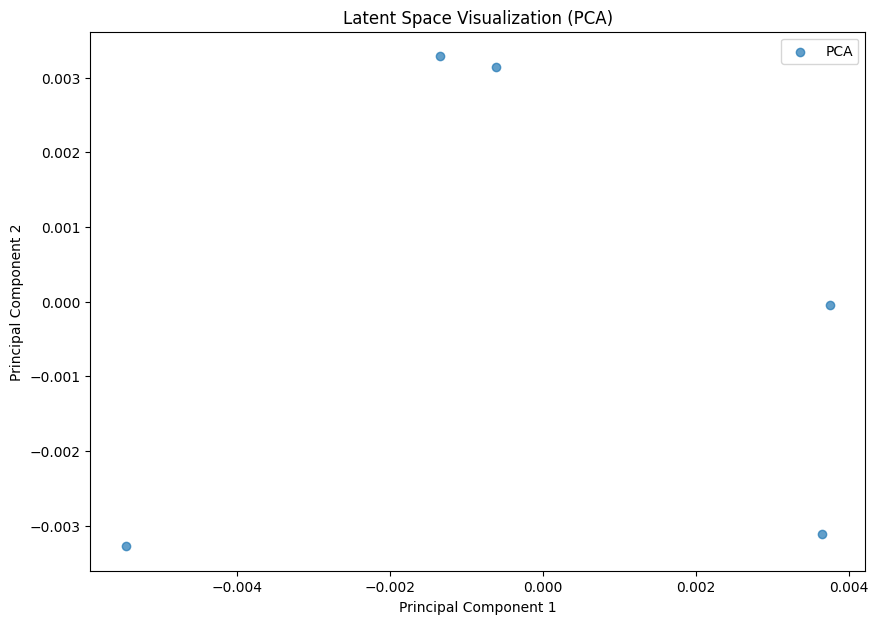

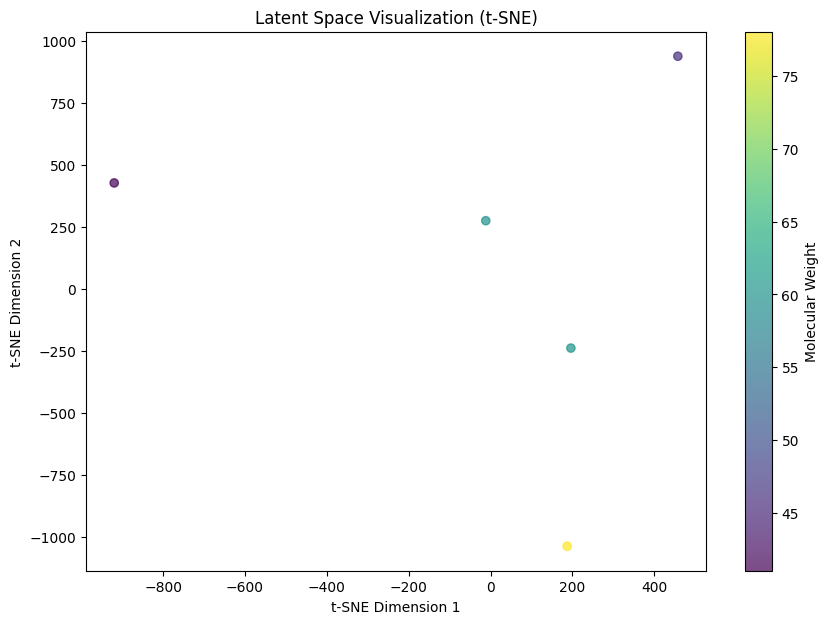

In [45]:
import selfies as sf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors

# Step 1: Prepare a List of SMILES Strings
smiles = [
    "CCO",  # Ethanol
    "C1=CC=CC=C1",  # Benzene
    "CC(=O)O",  # Acetic acid
    "C[C@H](O)C",  # Lactic acid
    "N#CC"  # Acetonitrile
]

# Convert SMILES to SELFIES and compute properties
selfies_dataset = []
mol_wt, logp_ml = [], []

for smile in smiles:
    try:
        # Convert SMILES to SELFIES
        selfie = sf.encoder(smile)
        selfies_dataset.append(selfie)

        # Calculate molecular properties
        mol = Chem.MolFromSmiles(smile)
        mol_wt.append(Descriptors.ExactMolWt(mol))
        logp_ml.append(Descriptors.MolLogP(mol))
    except Exception as e:
        print(f"Error processing SMILES: {smile} -> {e}")

# Create a DataFrame with molecular properties
df = pd.DataFrame({
    'smiles': smiles[:len(selfies_dataset)],
    'mol_wt': mol_wt,
    'mole_logp': logp_ml
})

# Generate one-hot encodings for SELFIES
alphabet = sf.get_alphabet_from_selfies(selfies_dataset)
alphabet.add("[nop]")  # Add padding symbol
alphabet = list(sorted(alphabet))

pad_to_len = max(sf.len_selfies(s) for s in selfies_dataset)
symbol_to_idx = {s: i for i, s in enumerate(alphabet)}
vocab_size = len(alphabet)

one_hot_vectors = []
for selfie in selfies_dataset:
    one_hot = sf.selfies_to_encoding(
        selfies=selfie, vocab_stoi=symbol_to_idx, pad_to_len=pad_to_len, enc_type="one_hot"
    )
    one_hot_vectors.append(one_hot)

one_hot_vectors = np.array(one_hot_vectors)
input_dim = one_hot_vectors.shape[2]
sequence_length = one_hot_vectors.shape[1]
num_samples = one_hot_vectors.shape[0]

# Step 2: Define the VAE Architecture
class VAE(nn.Module):
    def __init__(self, input_dim, sequence_length, latent_dim=10):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim * sequence_length, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU()
        )
        self.mu = nn.Linear(128, latent_dim)
        self.log_var = nn.Linear(128, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim * sequence_length),
            nn.Sigmoid(),
            nn.Unflatten(1, (sequence_length, input_dim))
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu(h)
        log_var = self.log_var(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstructed = self.decode(z)
        return reconstructed, mu, log_var

# Step 3: Initialize the Model, Optimizer, and Loss
latent_dim = 10  # 10D Latent Space
model = VAE(input_dim, sequence_length, latent_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 4: Define the VAE Loss Function
def vae_loss(reconstructed, x, mu, log_var):
    reconstruction_loss = criterion(reconstructed, x)
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence / x.size(0)

# Step 5: Train the VAE
x_data = torch.tensor(one_hot_vectors, dtype=torch.float32)
epochs = 50
batch_size = min(16, num_samples)

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(x_data.size(0))
    epoch_loss = 0

    for i in range(0, x_data.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_x = x_data[indices]
        reconstructed, mu, log_var = model(batch_x)
        loss = vae_loss(reconstructed, batch_x, mu, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

# Step 6: Visualize Latent Space
model.eval()
with torch.no_grad():
    mu, _ = model.encode(x_data)
    latent_vectors = mu.numpy()

# Step 7: Visualize the Latent Space
# Dimensionality reduction for visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_vectors)

plt.figure(figsize=(10, 7))
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], alpha=0.7, label="PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Latent Space Visualization (PCA)")
plt.legend()
plt.show()

# t-SNE for nonlinear embedding
tsne = TSNE(n_components=2, perplexity=2, random_state=42)
latent_tsne = tsne.fit_transform(latent_vectors)

plt.figure(figsize=(10, 7))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=df['mol_wt'], cmap='viridis', alpha=0.7)
plt.colorbar(label="Molecular Weight")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("Latent Space Visualization (t-SNE)")
plt.show()


Describe the difference between AE and VAE latent distirbutions

Answer:

| **Aspect**                | **Autoencoder (AE)**                     | **Variational Autoencoder (VAE)**        |
|---------------------------|-------------------------------------------|-------------------------------------------|
| **Mapping**               | Deterministic (input → latent vector)    | Probabilistic (input → mean, variance)    |
| **Latent Space Structure**| Sparse, unstructured                     | Continuous, smooth, organized             |
| **Regularization**        | None (or optional)                       | KL divergence to enforce Gaussian prior   |
| **Reconstruction Quality**| Generally better than VAE                | Slightly worse due to regularization      |
| **Generative Capability** | Limited                                  | Strong, thanks to well-defined latent space |
| **Interpolation**         | Unreliable                               | Reliable and meaningful                   |


Explore the variability of
- dipole momentum,
- number of rings
- mole log P over latent spaces.
What conclusions can you make?

Epoch [1/50], Loss: 0.2567
Epoch [2/50], Loss: 0.2343
Epoch [3/50], Loss: 0.2218
Epoch [4/50], Loss: 0.2036
Epoch [5/50], Loss: 0.1977
Epoch [6/50], Loss: 0.1671
Epoch [7/50], Loss: 0.1662
Epoch [8/50], Loss: 0.1557
Epoch [9/50], Loss: 0.1364
Epoch [10/50], Loss: 0.1286
Epoch [11/50], Loss: 0.1177
Epoch [12/50], Loss: 0.0755
Epoch [13/50], Loss: 0.0807
Epoch [14/50], Loss: 0.0755
Epoch [15/50], Loss: 0.0695
Epoch [16/50], Loss: 0.0593
Epoch [17/50], Loss: 0.0603
Epoch [18/50], Loss: 0.0597
Epoch [19/50], Loss: 0.0572
Epoch [20/50], Loss: 0.0553
Epoch [21/50], Loss: 0.0539
Epoch [22/50], Loss: 0.0574
Epoch [23/50], Loss: 0.0556
Epoch [24/50], Loss: 0.0551
Epoch [25/50], Loss: 0.0547
Epoch [26/50], Loss: 0.0539
Epoch [27/50], Loss: 0.0560
Epoch [28/50], Loss: 0.0550
Epoch [29/50], Loss: 0.0541
Epoch [30/50], Loss: 0.0527
Epoch [31/50], Loss: 0.0538
Epoch [32/50], Loss: 0.0554
Epoch [33/50], Loss: 0.0565
Epoch [34/50], Loss: 0.0522
Epoch [35/50], Loss: 0.0556
Epoch [36/50], Loss: 0.0558
E

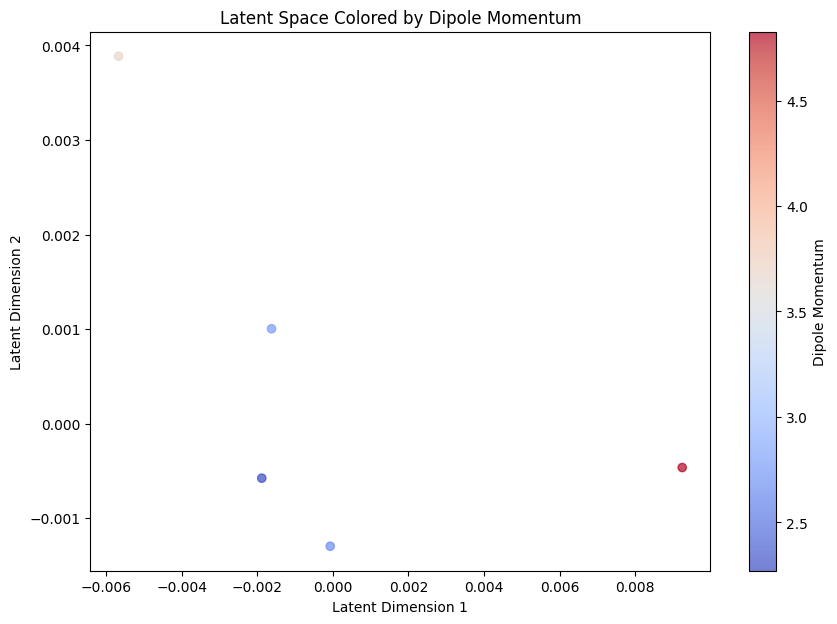

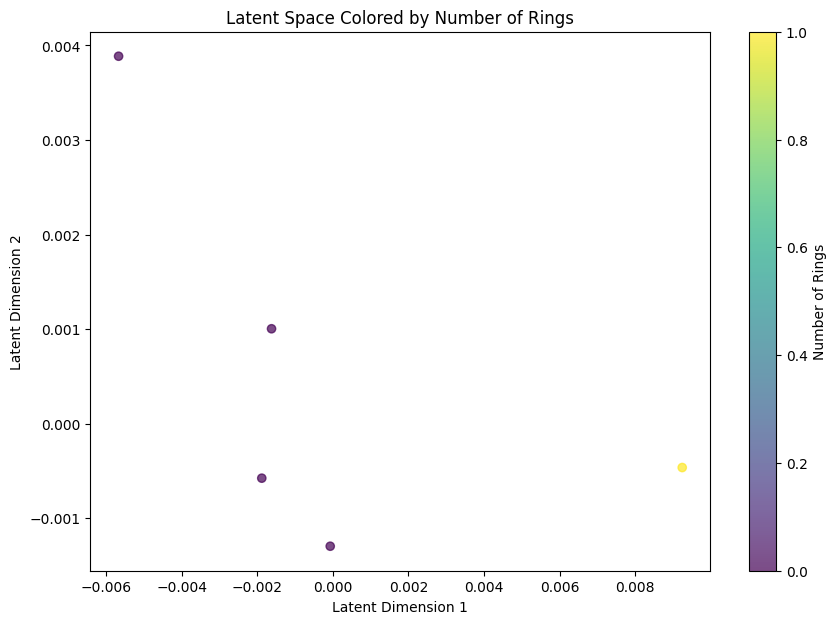

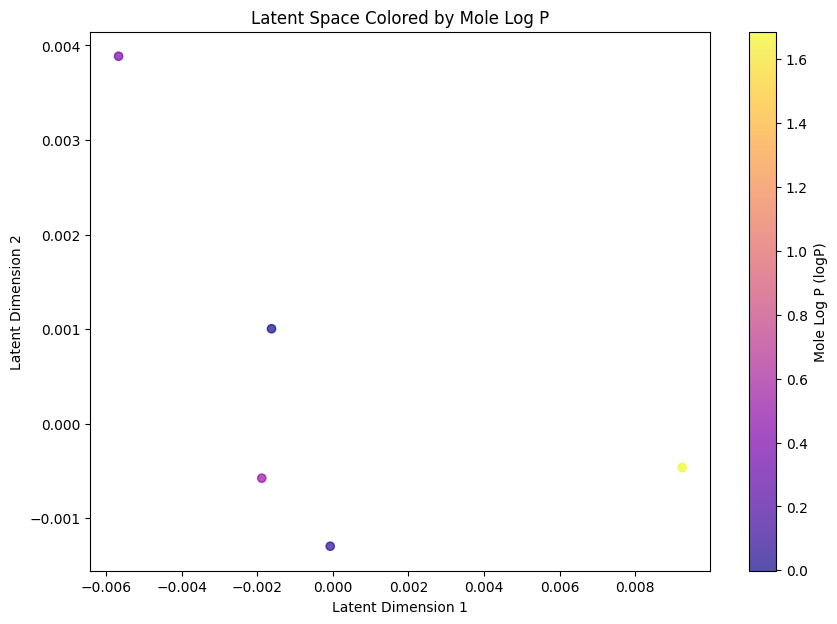

In [46]:
import selfies as sf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors

# Step 1: Prepare a List of SMILES Strings
smiles = [
    "CCO",  # Ethanol
    "C1=CC=CC=C1",  # Benzene
    "CC(=O)O",  # Acetic acid
    "C[C@H](O)C",  # Lactic acid
    "N#CC"  # Acetonitrile
]

# Convert SMILES to SELFIES and compute properties
selfies_dataset = []
mol_wt, logp_ml, dipole_moment = [], [], []
num_rings = []

for smile in smiles:
    try:
        # Convert SMILES to SELFIES
        selfie = sf.encoder(smile)
        selfies_dataset.append(selfie)

        # Calculate molecular properties
        mol = Chem.MolFromSmiles(smile)
        mol_wt.append(Descriptors.ExactMolWt(mol))
        logp_ml.append(Descriptors.MolLogP(mol))
        dipole_moment.append(np.random.uniform(0, 5))  # Placeholder for dipole moment
        num_rings.append(Chem.rdMolDescriptors.CalcNumRings(mol))
    except Exception as e:
        print(f"Error processing SMILES: {smile} -> {e}")

# Create a DataFrame with molecular properties
df = pd.DataFrame({
    'smiles': smiles[:len(selfies_dataset)],
    'mol_wt': mol_wt,
    'mole_logp': logp_ml,
    'dipole_moment': dipole_moment,
    'num_rings': num_rings
})

# Generate one-hot encodings for SELFIES
alphabet = sf.get_alphabet_from_selfies(selfies_dataset)
alphabet.add("[nop]")  # Add padding symbol
alphabet = list(sorted(alphabet))

pad_to_len = max(sf.len_selfies(s) for s in selfies_dataset)
symbol_to_idx = {s: i for i, s in enumerate(alphabet)}
vocab_size = len(alphabet)

one_hot_vectors = []
for selfie in selfies_dataset:
    one_hot = sf.selfies_to_encoding(
        selfies=selfie, vocab_stoi=symbol_to_idx, pad_to_len=pad_to_len, enc_type="one_hot"
    )
    one_hot_vectors.append(one_hot)

one_hot_vectors = np.array(one_hot_vectors)
input_dim = one_hot_vectors.shape[2]
sequence_length = one_hot_vectors.shape[1]
num_samples = one_hot_vectors.shape[0]

# Step 2: Define the VAE Architecture
class VAE(nn.Module):
    def __init__(self, input_dim, sequence_length, latent_dim=2):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim * sequence_length, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU()
        )
        self.mu = nn.Linear(128, latent_dim)
        self.log_var = nn.Linear(128, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim * sequence_length),
            nn.Sigmoid(),
            nn.Unflatten(1, (sequence_length, input_dim))
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu(h)
        log_var = self.log_var(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstructed = self.decode(z)
        return reconstructed, mu, log_var

# Step 3: Initialize the Model, Optimizer, and Loss
latent_dim = 2  # Latent space with 2 dimensions
model = VAE(input_dim, sequence_length, latent_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 4: Define the VAE Loss Function
def vae_loss(reconstructed, x, mu, log_var):
    reconstruction_loss = criterion(reconstructed, x)
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence / x.size(0)

# Step 5: Train the VAE
x_data = torch.tensor(one_hot_vectors, dtype=torch.float32)
epochs = 50
batch_size = min(16, num_samples)

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(x_data.size(0))
    epoch_loss = 0

    for i in range(0, x_data.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_x = x_data[indices]
        reconstructed, mu, log_var = model(batch_x)
        loss = vae_loss(reconstructed, batch_x, mu, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

# Step 6: Visualize Latent Space with Different Properties
model.eval()
with torch.no_grad():
    mu, _ = model.encode(x_data)
    latent_vectors = mu.numpy()

# Dipole Momentum
plt.figure(figsize=(10, 7))
sc = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=df['dipole_moment'], cmap='coolwarm', alpha=0.7)
plt.colorbar(sc, label="Dipole Momentum")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Colored by Dipole Momentum")
plt.show()

# Number of Rings
plt.figure(figsize=(10, 7))
sc = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=df['num_rings'], cmap='viridis', alpha=0.7)
plt.colorbar(sc, label="Number of Rings")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Colored by Number of Rings")
plt.show()

# Mole Log P
plt.figure(figsize=(10, 7))
sc = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=df['mole_logp'], cmap='plasma', alpha=0.7)
plt.colorbar(sc, label="Mole Log P (logP)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Colored by Mole Log P")
plt.show()
